In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

import numpy as np
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stack = 'ChatCryoJane201710'
first_sec, last_sec = metadata_cache['section_limits'][stack]

In [3]:
clfs = DataManager.load_classifiers(classifier_id=999, structures=['7N'])

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [ ]:
structure = '7N'

for sec in metadata_cache['valid_sections'][stack]:
# for sec in [115]:

    out_resolution_um = 10.
    
    viz, sm = draw_scoremap(clf=clfs['7N'], 
                            scheme='normalize_mu_region_sigma_wholeImage_(-1,5)', 
#                             bbox=(11217, 16886, 13859, 18404),
                            win_id=7,
                            stack=stack, return_scoremap=True, sec=sec,
                            model=model, 
                             mean_img=mean_img, 
                             batch_size=batch_size,
                           out_resolution_um=out_resolution_um)
    
    scoremap_bp_filepath = \
    DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                 structure=structure,
                                                 detector_id=999,
                                                 out_resolution_um=out_resolution_um)

    create_parent_dir_if_not_exists(scoremap_bp_filepath)
    bp.pack_ndarray_file(sm.astype(np.float16), scoremap_bp_filepath)
    upload_to_s3(scoremap_bp_filepath)
    
    
    viz_filepath = \
    DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                 structure=structure,
                                                 detector_id=999,
                                                 out_resolution_um=out_resolution_um)

    create_parent_dir_if_not_exists(viz_filepath)
    imsave(viz_filepath, viz)
    upload_to_s3(viz_filepath)

locate patches: 0.04 seconds
Not using image_cache.
Load image: 8.57 seconds.
Resize patches from 316 x 316 to 224 x 224.
Extract patches: 106.20 seconds


(19551, 1, 224, 224)


Not using image_cache.


(724, 987, 3) (724, 987)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/ChatCryoJane201710/ChatCryoJane201710_prep2_10.0um_detector999/ChatCryoJane201710_slide1-S1_prep2_10.0um_detector999/ChatCryoJane201710_slide1-S1_prep2_10.0um_detector999_7N_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/ChatCryoJane201710/ChatCryoJane201710_prep2_10.0um_detector999/ChatCryoJane201710_slide1-S1_prep2_10.0um_detector999/ChatCryoJane201710_slide1-S1_prep2_10.0um_detector999_7N_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/7N/ChatCryoJane201710/detector999/prep2/ChatCryoJane201710_slide1-S1_prep2_10.0um_7N_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/7N/ChatCryoJane201710/detector999/prep2/ChatCryoJane201710_slide1-S1_prep2_10.0um_7N_detector999_scoremapViz.jpg"


locate patches: 0.06 seconds
Not using image_cache.
Load image: 8.57 seconds.
Resize patches from 316 x 316 to 224 x 224.
Extract patches: 108.13 seconds


(19880, 1, 224, 224)


Not using image_cache.


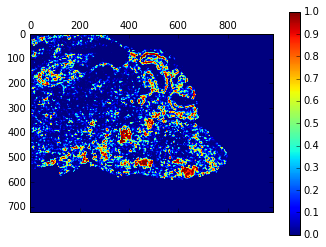

In [40]:
%matplotlib inline
plt.figure(figsize=(10,10));
plt.matshow(sm);
plt.colorbar();

In [41]:
display_image(viz)

/home/yuncong/Brain/learning/tmp.jpg